In [14]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import itertools

from matplotlib.mlab import bivariate_normal
%matplotlib inline

### The Bootstrap and Robust Divergences

##### A Mispecified Model with Outliers

Let's draw data from a Student-T but with some outliers drawn from a shifted Cauchy.

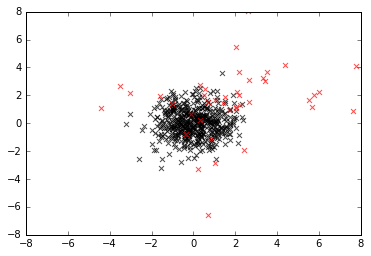

In [49]:
N_true = 500
N_outlier = 50
N = N_true + N_outlier

true_obs = np.random.standard_t(df=100, size=(N_true, 2))
noise_obs = np.random.standard_cauchy(size=(N_outlier, 2)) + 2.
#noise_obs = np.array([[0., 0.]])
data = np.vstack([true_obs, noise_obs])
np.random.shuffle(data)

plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.show()

##### Maximum Likelihood Estimate

Let's see what a Normal model fit to the data looks like

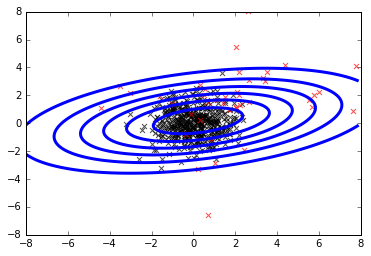

In [54]:
mu = np.mean(data, axis=0)
sigma = np.cov(data.T)

plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

x = np.arange(-8., 8., 0.1)
y = np.arange(-8., 8., 0.1)
X, Y = np.meshgrid(x, y)

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma[0,0]), sigmay=np.sqrt(sigma[1,1]), mux=mu[0], muy=mu[1], sigmaxy=sigma[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.show()

##### Bootstrap Estimate

Let's try bootstrapping...

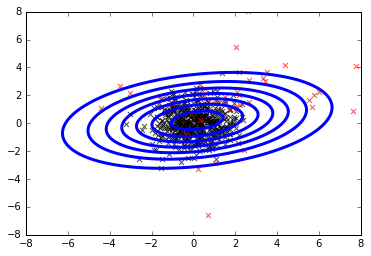

In [58]:
def uniform_bootstrap_resample(X, n=None, labels=None):
    """ Bootstrap resample an array_like
        Parameters
        ----------
        X : array_like
        data to resample
        n : int, optional
        length of resampled array, equal to len(X) if n==None
        Results
        -------
        returns X_resamples
        """
    if n == None:
        n = len(X)
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    if labels != None:
        Y_resample = labels[resample_i]
        return X_resample, Y_resample
    return X_resample

mu_avg = np.zeros((2,))
sigma_avg = np.zeros((2,2))
K = 3

for k in xrange(K):
    X_k = uniform_bootstrap_resample(data, N)
    mu_avg += np.mean(X_k, axis=0)
    sigma_avg += np.cov(X_k.T)
mu_avg /= K
sigma_avg /= K


plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma_avg[0,0]), sigmay=np.sqrt(sigma_avg[1,1]), mux=mu_avg[0], muy=mu_avg[1], sigmaxy=sigma_avg[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.show()

##### Power Divergence

Let's try using a robust diverenge for model fitting...